In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from chewc.core import *


In [ ]:
#| hide
from chewc.core import *
from chewc.trait import *
from chewc.meiosis import *
from chewc.crossing import *


import torch
import attr
import matplotlib.pyplot as plt


# ChewC

> Pytorch Breeding

In short, this will be a GPU-enabled stochastic simulation for breeding programs with an emphasis on cost-benefit-analysis for novel breeding tools and creating a suitable interface for RL agents.


---
We will also incorporate an emphasis on budget and costs associated with each action to manage long-term breeding budgets. As well as model theoretical tools in the plant breeder's toolbox. e.g.

> a treatment which increases crossover rates

> a treatment which reduces flowering time

> a treatment which enables gene drive at select loci

Each treatment will cost $$ ultimately helping guide the implementation in real-world breeding programs.


## Install

```sh
pip install chewc
```

## How to use

First, define the genome of your crop

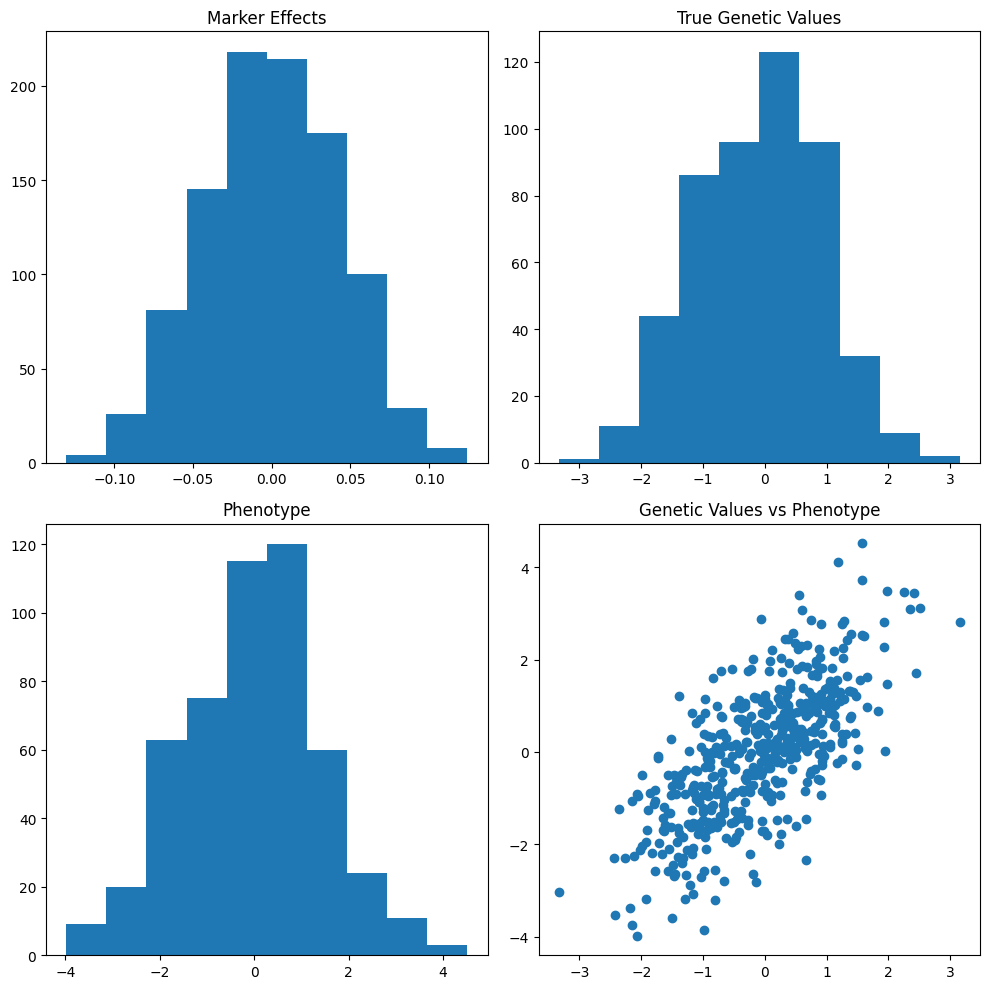

In [ ]:
ploidy = 2
number_chromosomes = 10
loci_per_chromosome = 100
genetic_map = create_random_genetic_map(number_chromosomes,loci_per_chromosome)
crop_genome = Genome(ploidy, number_chromosomes, loci_per_chromosome, genetic_map)

n_founders = 500
founder_pop = create_random_founder_pop(crop_genome , n_founders)
simparam = SimParam
simparam.founder_pop = founder_pop
simparam.genome = crop_genome


#add a single additive trait
qtl_loci = 100
qtl_map = select_qtl_loci(qtl_loci,simparam.genome)

ta = TraitA(qtl_map,simparam,0, 1)
ta.sample_initial_effects()
ta.scale_genetic_effects()
ta.calculate_intercept()

# Create a 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # Adjust figsize as needed

# Plot 1: Scaled Effects Histogram
axs[0, 0].hist(ta.scaled_effects.flatten())
axs[0, 0].set_title('Marker Effects')

# Plot 2: True Genetic Values Histogram
genetic_values = ta.calculate_genetic_values(simparam.founder_pop)
axs[0, 1].hist(genetic_values)
axs[0, 1].set_title('True Genetic Values')

# Plot 3: Phenotype Histogram
phenotypes = ta.phenotype(simparam.founder_pop, h2=0.5)  # Assuming 'h2' is a parameter for heritability in the phenotype method
axs[1, 0].hist(phenotypes)
axs[1, 0].set_title('Phenotype')

# Plot 4: Scatter Plot of Genetic Values vs Phenotypes
axs[1, 1].scatter(genetic_values, phenotypes)
axs[1, 1].set_title('Genetic Values vs Phenotype')

# Display the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()